# Recurrent Neural Networks

Here we will set up a simple example where we will try to predict if the stock market price for a company is going to be **high** (1.0), **medium** (0.5), or **low** (0.0) given the price over the previous two days.

First, let's set up a simple plot to view the stock of a company over time:

In [261]:
import matplotlib.pyplot as plt
from random import choice
from IPython.display import Image

In [696]:
def stock_market_figure(observations, predicted_value=None, predictions=None, expected=None):
    plt.figure(figsize=(2*len(observations)+1,3))
    
    times = [i for i in range(0, len(observations))]
    
    # Plot a series of expectations
    if expected != None:        
        expected_time = [i for i in range(1, len(expected)+1)]
        plt.plot(
            expected_time,
            expected,
            linestyle="-",
            color="black",
            alpha=0.7,
            marker="o",
            markeredgecolor="grey",
            markerfacecolor="#4ca32c",
            markeredgewidth=2,
            markersize=25,
            label="Expected"
        )
    
    # Plot a series of predicted values
    if predictions != None:
        prediction_time = [i for i in range(1, len(predictions)+1)]
        plt.plot(
            prediction_time,
            predictions,
            alpha=0.5,
            linestyle="--",
            color="black",
            marker="o",
            markeredgecolor="grey",
            markerfacecolor="#adadad",
            markeredgewidth=2,
            markersize=25,
            label="Predicted"
        )
    
    if predicted_value != None:
        # Set the predicted value and time after the last observation
        prediction = [observations[-1], predicted_value]
        prediction_time = [len(observations)-1, len(observations)]
        
        # Plot the prediction
        plt.plot(
            prediction_time,
            prediction,
            linestyle="--",
            color="black",
            marker="o",
            markeredgecolor="grey",
            markerfacecolor="lightgrey",
            markeredgewidth=2,
            markersize=25,
            label="Predicted"
        )
    
    # Plot the observations
    plt.plot(
        times, 
        observations,
        linestyle="-",
        color="black",
        marker="o",
        markeredgecolor="black",
        markerfacecolor="#4ca32c",
        markeredgewidth=1.5,
        markersize=25,
        label="Observed"
        )
    
    # Set the x labels based on the number of observations
    xlabels = []
    for i in range(0, len(observations) + 1):
        label = f"Day {i}"
        if i == len(observations):
            label = "Tomorrow"
        if i == len(observations)-1:
            label = "Today"
        if i == len(observations)-2:
            label = "Yesterday"
        elif i < len(observations)-2:
            label = f"{len(observations)-1-i} Days Ago"
        xlabels.append(label)
        
    
    plt.title("Stock Prices over Time", fontsize=16)
    plt.ylabel("Stock Price", fontsize=16)
    plt.xticks([i for i in range(0, len(observations) + 1)], labels=xlabels, fontsize=12)
    plt.yticks([0, 0.5, 1], labels=["Low\n0", "Medium\n0.5", "High\n1"], fontsize=12)
    plt.xlim((-0.5, len(observations) + 1))
    plt.ylim((-0.25, 1.25))
    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1.01, 1),  # slightly outside to the right
        borderaxespad=0,
        fontsize=12
    )
    
    # Set the spines of the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(width=2, length=6)
    
    plt.tight_layout()
    plt.show()

We can write the expected logic to check the predictions of our model. 

**Possible Scenarios:**
1. If the stock prices go up, we expect the stock prices to keep going up (to a maximum of "high")
2. If the stock prices go down, we expect the stock prices to keep going down (to a minimum of "low)
3. If the stock prices stay the same, we expect the stock prices to remain the same

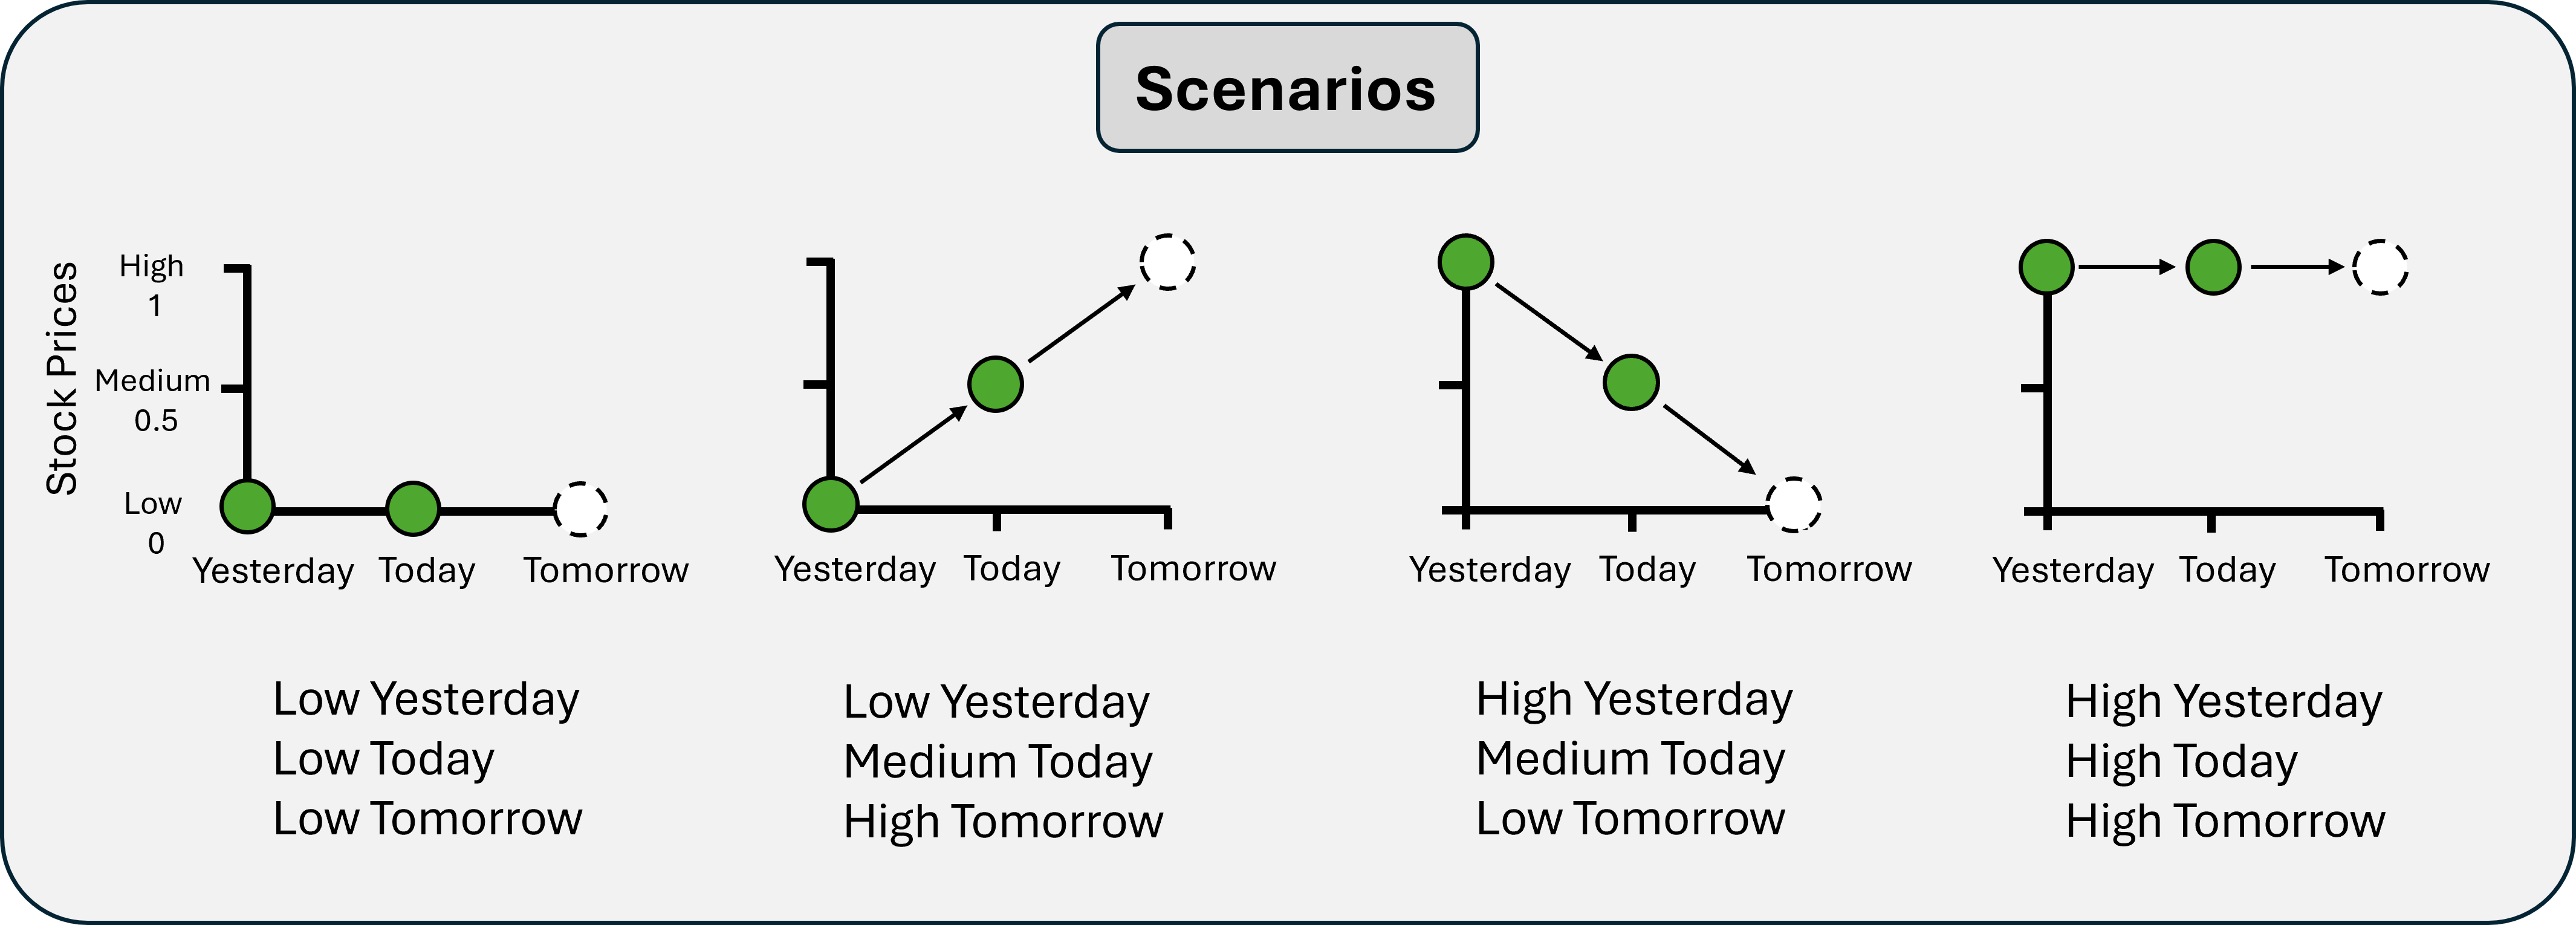

In [ ]:
Image(filename='images/rnn_stock_scenarios.png', width=1000) 

In [343]:
def expected_logic(observations):
    # Stock prices stayed the same, predict stays the same
    if observations[-2] == observations[-1]:
        return float(observations[-1])
    
    # Stock prices went down, predict keeps going down
    if observations[-2] > observations[-1]:
        return max(0.0, observations[-1] - 0.5)
    
    # Stock prices went up, predict keeps going up
    if observations[-2] < observations[-1]:
        return min(1.0, observations[-1] + 0.5)

Once we have a function to check the expected logic, we can generate some random observations which fit the possibilities

In [536]:
def generate_random_observations(num_obs):
    first_choice = choice([0, 0.5, 1.0])
    rand_yesterday = first_choice
    
    rand_obs = [first_choice]
    for i in range(0, num_obs-1):
        if rand_yesterday == 0.0:
            rand_today = choice([0, 0.5])
        if rand_yesterday == 0.5:
            rand_today = choice([0, 0.5, 1.0])
        if rand_yesterday == 1.0:
            rand_today = choice([0.5, 1.0])
        rand_obs.append(float(rand_today))
        
        rand_yesterday = rand_today
    return rand_obs

We can run the following cell several times to check that the `generate_random_observations()` and `expected_logic` functions fit with our expectations.

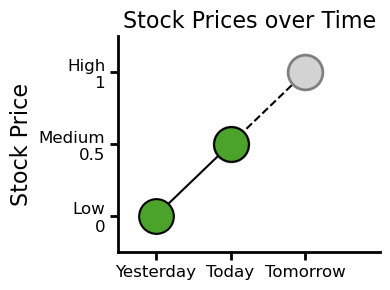

In [656]:
rand_obs = generate_random_observations(2)
prediction = expected_logic(rand_obs)
stock_market_figure(rand_obs, prediction)

## Creating a Recurrent Neural Network (RNN)
Now that we have a way to create observations, verify predictions, and visualize the results, let's start building a **Recurrent Neural Network** to make these predictions.

An RNN is made up of a bunch of repeating units that predict the value of a single time point called **recurrent units**. These recurrent units all have the same architecture, with **shared weights and biases**.

Here is what one of these units looks like for the current problem:

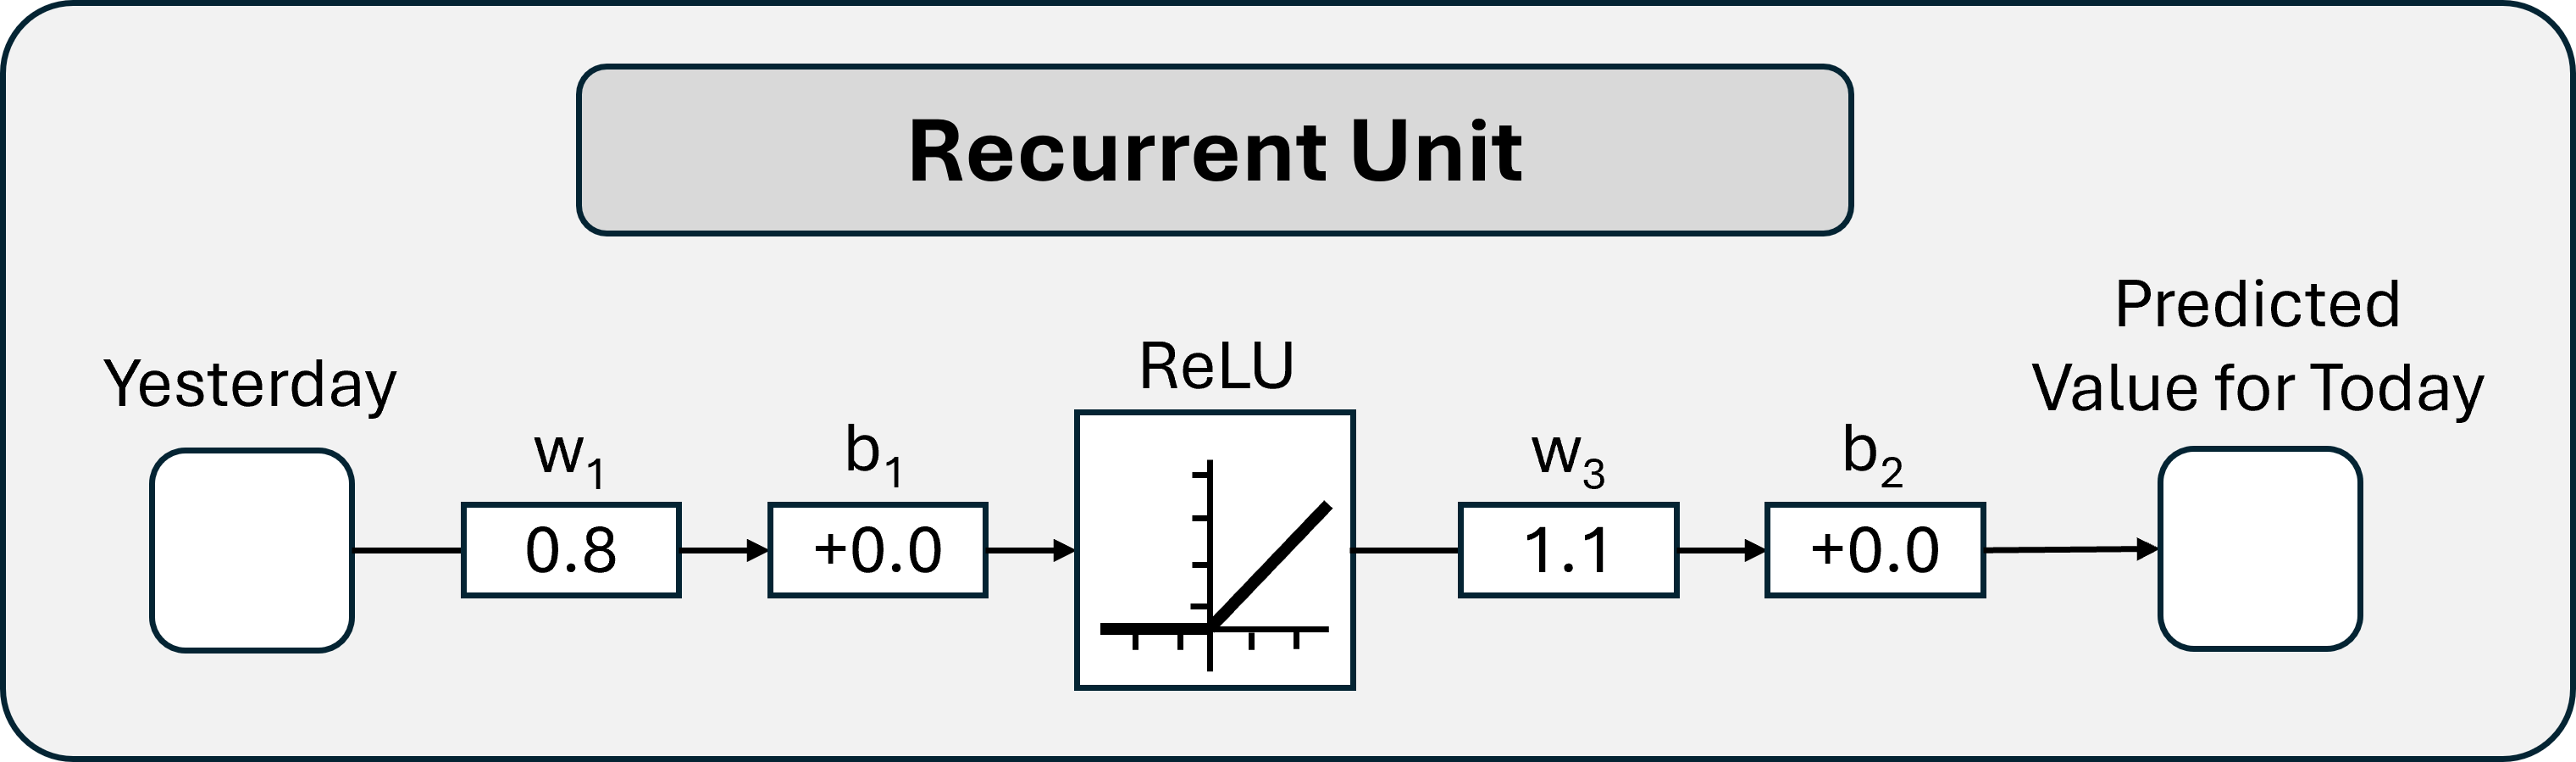

In [264]:
Image(filename='images/rnn_recurrent_unit.png', width=1000) 

This recurrent unit predicts the value for today, given the input of yesterday. It consists of three main components:

1. A weight and bias applied to the input
2. An activation function (in this case the ReLU function)
3. A weight and bias applied to the result of the activation function

What makes the recurrent unit special is that we can combine multiple recurrent units together, one for each time point:

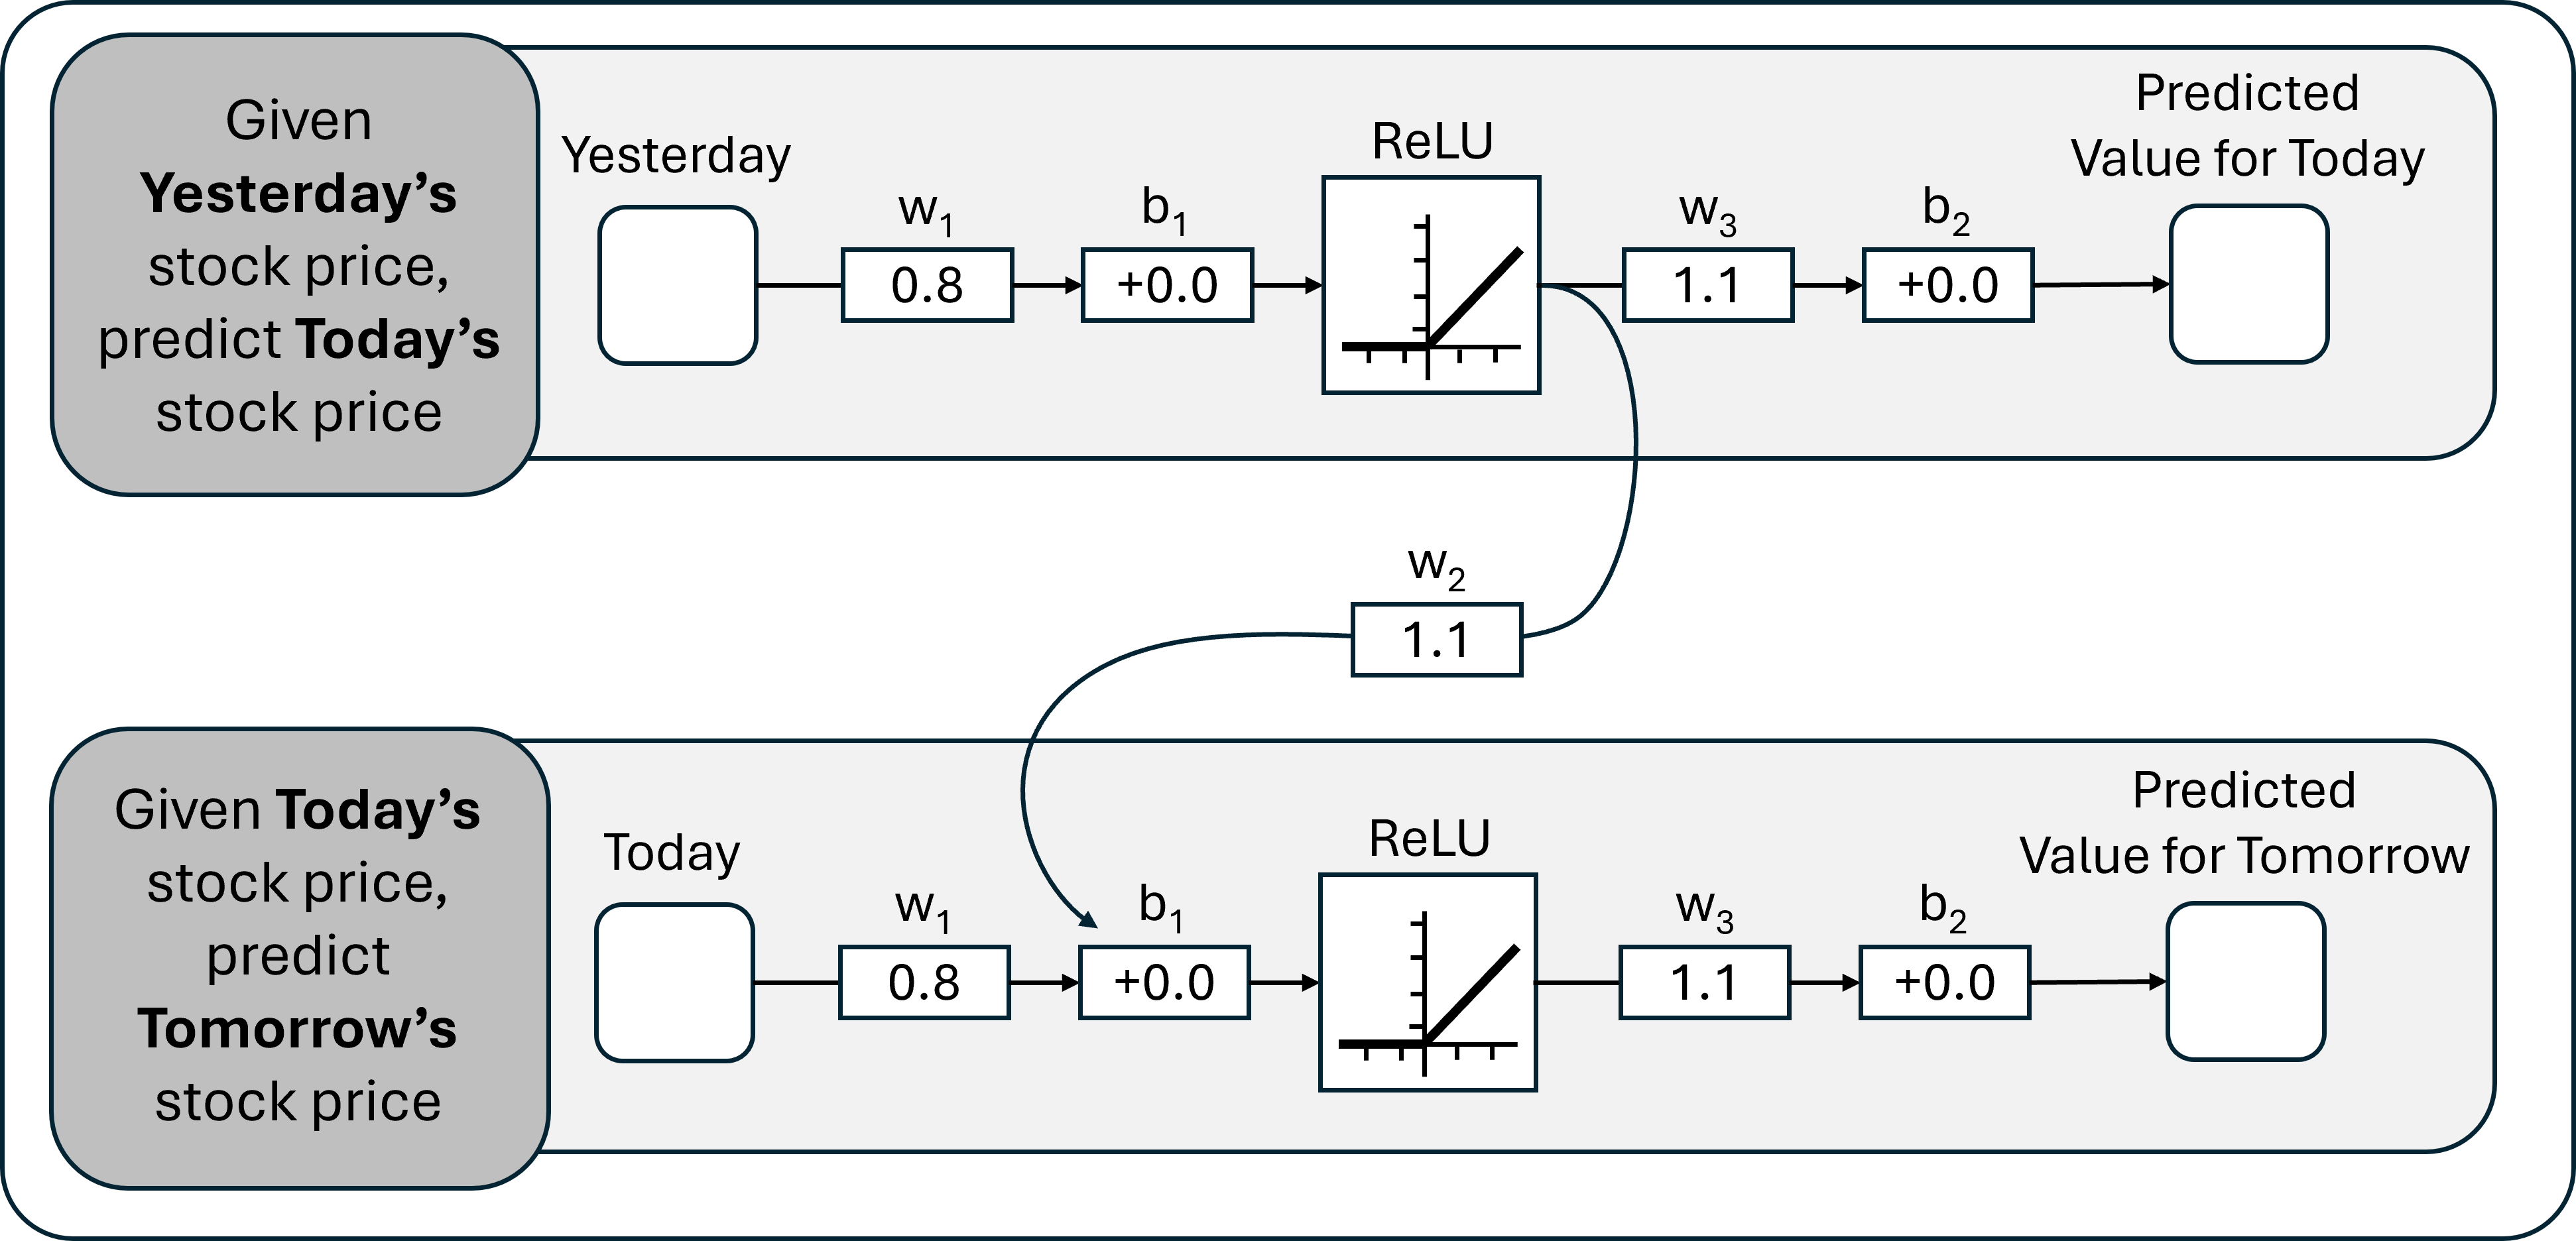

In [266]:
Image(filename='images/rnn_multiple_recurrent_units.png', width=1000) 

The network also passes information from one time point to the next. It accomplishes this by passing the **result from the activation function** ($y_{1}$) of the previous time point, also called the recursive unit's **hidden state**, multiplied by a **weight** ($w_{3}$ in this case) to the next time point. This is **added** to the result of $(\text{input} \times w_{1})$, then the bias is added to that result. The equation passed to the activation function of the next time point's recursive unit then looks like:

$(y_{1} \times w_{2}) + (\text{input} \times w_{1}) + b_{1}$
 
This means that the input to the activation function of the **current** recursive unit is influenced by the output of the activation function of the **previous** recursive unit, and the activation function of the previous recursive unit is influenced by the prediction for the unit before it, and so on back until the first time point. In this way, information about previous states is retained throughout the entire network.

Let's set up the logic for a recurrent unit:

In [324]:
def recurrent_unit(input, previous_hidden_state=None, verbose=False):
    weight_1 = 1.8
    weight_2 = -0.5
    weight_3 = 1.1
    
    bias_1 = 0.0
    bias_2 = 0.0
    
    def calculate_activation_function_input(previous_hidden_state):
        """Calculates the first part of the equation"""
        if previous_hidden_state != None:
            if verbose:
                print(f"  Input for Activation Function \n\t= (input * weight_1) + (previous_hidden_state * weight_2) + bias_1 \n\t= ({input} * {weight_1}) + ({previous_hidden_state} * {weight_2}) + {bias_1} \n\t= {(input * weight_1) + (previous_hidden_state * weight_2) + bias_1}")
            return (input * weight_1) + (previous_hidden_state * weight_2) + bias_1
        
        elif previous_hidden_state == None:
            if verbose:
                print(f"  Input for Activation Function \n\t= (input * weight_1) + bias_1 \n\t= ({input} * {weight_1}) + {bias_1} \n\t= {(input * weight_1) + bias_1}")
            return (input * weight_1) + bias_1
        
    def relu(input):
        return max(0, input)
    
    def calculate_prediction(current_hidden_state):
        """Calculates the prediction for the next day based on the hidden state"""
        if verbose:
            print(f"  Prediction \n\t= (current_hidden_state * weight_3) + bias_2 \n\t= ({current_hidden_state} * {weight_3}) + {bias_2} \n\t= {round((current_hidden_state * weight_3) + bias_2,1)}")
        return (current_hidden_state * weight_3) + bias_2
        
    
    activation_function_input = calculate_activation_function_input(previous_hidden_state)
    
    current_hidden_state = relu(activation_function_input)
    if verbose:
        print(f"  Current hidden state \n\t= max(0, {activation_function_input}) \n\t= {current_hidden_state}")
    
    current_prediction = calculate_prediction(current_hidden_state)
    
    return current_hidden_state, current_prediction

This recurrent unit takes in an **input** and a **possible previous hidden state** (there is no previous hidden state if it's the first unit) and returns it's **hidden state** and it's **prediction** about the next time point. 

Now, let's create a chain of recurrent units that will predict the stock price of a company, given the stock prices of yesterday and today. Since we are working with data from **two time points** (yesterday and today), we will create **two connected recurrent units**.

In [325]:
# First, we need to have stock prices for yesterday and today as input
yesterdays_stock_price = 0
todays_stock_price = 0.5

print("Yesterday's recurrent unit")
yesterdays_hidden_state, todays_prediction = recurrent_unit(yesterdays_stock_price, verbose=True)

print("\nToday's recurrent unit")
todays_hidden_state, tomorrows_prediction = recurrent_unit(todays_stock_price, yesterdays_hidden_state, verbose=True)

print(f"\nTomorrow's predicted stock price = {round(tomorrows_prediction, 0)}")

Yesterday's recurrent unit
  Input for Activation Function 
	= (input * weight_1) + bias_1 
	= (0 * 1.8) + 0.0 
	= 0.0
  Current hidden state 
	= max(0, 0.0) 
	= 0
  Prediction 
	= (current_hidden_state * weight_3) + bias_2 
	= (0 * 1.1) + 0.0 
	= 0.0

Today's recurrent unit
  Input for Activation Function 
	= (input * weight_1) + (previous_hidden_state * weight_2) + bias_1 
	= (0.5 * 1.8) + (0 * -0.5) + 0.0 
	= 0.9
  Current hidden state 
	= max(0, 0.9) 
	= 0.9
  Prediction 
	= (current_hidden_state * weight_3) + bias_2 
	= (0.9 * 1.1) + 0.0 
	= 1.0

Tomorrow's predicted stock price = 1.0


Looking at the predictions, it may be confusing that the recurrent unit from **yesterday** predicted a value of **0.0** for today when the value of **today** was really **0.5**. This is **fine**, as we ignore the predicitons for all but the last recurrent unit (**we know the value of today**, we just need the recurrent unit to **pass along the information from yesterday**)

Let's set up the recurrent neural network in a more formal way, returning just the last prediction:

In [612]:
def recurrent_neural_network(stock_price_series):
    all_predictions = []
    hidden_state = 0
    prediction = 0
    
    # Iterate through the stock price series, using the recurrent unit with the last hidden state
    
    for price in stock_price_series:
        current_hidden_state, current_prediction = recurrent_unit(price, hidden_state)
        
        # Update the hidden state and latest prediction
        hidden_state = current_hidden_state
        prediction = current_prediction
        
        # Keep track of each prediction, we can use it for calculating error later
        all_predictions.append(current_prediction)
    
    return prediction, all_predictions

Now, we can use the randomized stock price generator and the stock market figure code to test out the predictions. We can change the number of random observations and the RNN will still work!

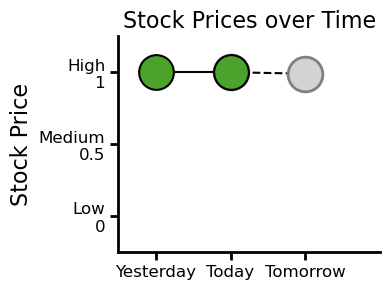

In [636]:
# stock_prices = generate_random_observations(2)
stock_prices = [1, 1]
predicted_stock_price, _ = recurrent_neural_network(stock_prices)

stock_market_figure(stock_prices, predicted_stock_price)

## Backpropagation Through Time
In order to calculate the effect each layer has on the loss, we need to take into account the error from each layer in the RNN. To do this, we use a concept called **Backpropagation Through Time (BTT)**. First, we need to set up an **objective function** that calculates the loss at each layer. Then to get the overall loss, we sum up the loss at each layer and take an average across all time points.

**Loss Function - Mean Squared Forecast Error (MSFE)**

$$L = \frac{1}{T}\sum^{T}_{t=1}(y_{t}-o_{t})^{2}$$

Where $y_{t}$ is the prediction at the current time step and $o_{t}$ is the expected output.

Stock prices: [0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 1.0, 0.5, 0.5]
Expected: [0.5, 0.5, 0.5, 0.0, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5]
Observed: [1.0, 0.5, 0.7, 0.6, 0.0, 1.0, 0.5, 1.7, 0.1, 0.9]
Final prediction: 0.9281250000000001


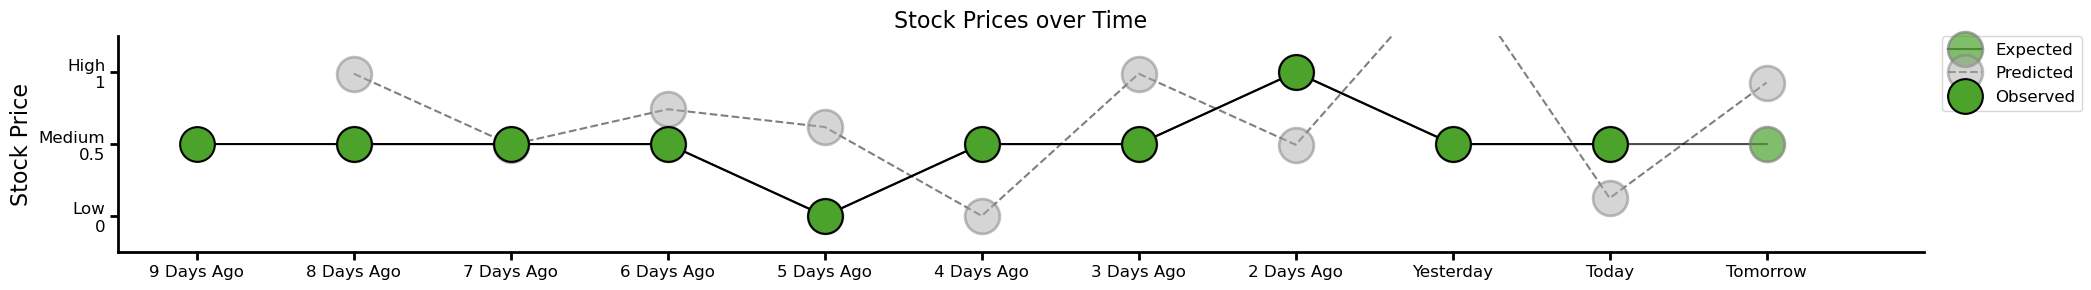

In [711]:
def calculate_msfe_loss(predictions, observations):
    mse_over_time = [(y-o)^2 for y, o in zip(predictions, observations)]
    loss = (1/len(observations)) * sum(mse_over_time)
    return loss

stock_prices = generate_random_observations(10)
predicted_stock_price, all_predictions = recurrent_neural_network(stock_prices)

# Add on the expected value for the last one
def create_expected(stock_price_observations):
    expected = [i for i in stock_price_observations[1:]]
    expected_last_price = expected_logic(stock_price_observations)
    expected.append(expected_last_price)
    return expected

expected = create_expected(stock_prices)
observed = all_predictions

print(f"Stock prices: {stock_prices}")
print(f"Expected: {expected}")
print(f"Observed: {[round(i,1) for i in observed]}")
print(f"Final prediction: {predicted_stock_price}")
stock_market_figure(stock_prices, predictions=observed, expected=expected)